In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

In [136]:
### Hyperparameters
n_epochs = 10
batch_size_train = 64
batch_size_test = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Load the Data

In [137]:
### Get MNIST Data

#train = True pulls from training set train = False pulls from testing data
#Compose() chains multiple transformations together
#ToTensor() transforms PIL image or numpy array to torch tensor
#Normalize() normalize a tensor image with mean and standard deviation (mean, std)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((32, 32)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((32, 32)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

### Visualize the Data

In [138]:
### Example Data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [139]:
### 1000 examples 1 color, 32 by 32
### 1000 target lables that corresponds to an example
print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

Index: 0
Example Shape: torch.Size([100, 1, 32, 32])
Target Shape : torch.Size([100])


<module 'matplotlib.pyplot' from '/anaconda3/envs/FunnelAI/lib/python3.6/site-packages/matplotlib/pyplot.py'>

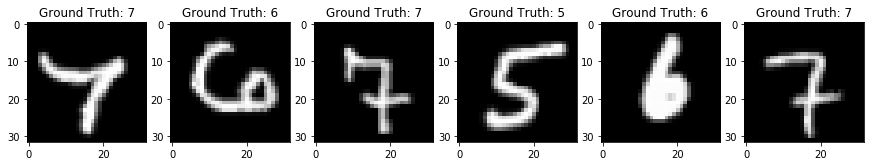

In [140]:
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

### LeNet CNN

In [265]:
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet, self).__init__()
        self.c1 = nn.Conv2d(1, 6, 5)  # input channel = 1, output channel = 6, kernel_size = 5
        self.c3 = nn.Conv2d(6, 16, 5)
        self.c5 = nn.Linear(16 * 5 * 5, 120) 
        self.f6 = nn.Linear(120, 84)
        self.OUTPUT = nn.Linear(84, 10)

        
    def forward(self, x):
        out1 = F.max_pool2d(F.relu(self.c1(x)), 2)  # pool size = 2
        out2 = F.max_pool2d(F.relu(self.c3(out1)), 2)
        out2 = out2.view(out2.size()[0], -1)             # x.view == np.reshape
        out3 = F.relu(self.c5(out2))
        out4 = F.relu(self.f6(out3))
        out5 = self.OUTPUT(out4)
        return out5
    
    def name(self):
        return "LeNet"

### Training

In [266]:
model = Lenet()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

In [267]:
### Create the Training Loop
for epoch in range(n_epochs):
    #training
    avg_loss = 0
    
    #loop through the training data
    for batch_idx, (x, label) in enumerate(train_loader):
        optimizer.zero_grad()                              #zero out the gradient for each minibatch
        x, label = Variable(x), Variable(label)
        output = model(x)                                  #get the output of the model fed forward
        loss = loss_function(output, label)                #calculate the loss of the output
        avg_loss = avg_loss * 0.9 + loss.item() * 0.1      #update the avg loss using momentum beta=.9
        loss.backward()                                    #back propagate
        optimizer.step()                                   #update the optimizer
        
        #print the current stats
        if (batch_idx+1) % 200 == 0 or (batch_idx+1) == len(train_loader):
            print ('**** epoch: {}, batch index: {}, train loss: {:.6f}'.format(epoch, batch_idx+1, avg_loss))


    #loop through the testing data for validation
    correct_pred = 0
    total_count = 0
    with torch.no_grad():
        for batch_idx, (x, label) in enumerate(test_loader):
            x, label = Variable(x), Variable(label) 
            output = model(x)
            loss = loss_function(output, label)
            _, pred_label = torch.max(output.data, 1)                  #return max of prediction array

            total_count += x.data.size()[0]                            #update total count with batch size
            correct_pred += (pred_label == label.data).sum().item()    #update correct predictions using sum of correct preds

            avg_loss = avg_loss * 0.9 + loss.item() * 0.1              #update loss

            if(batch_idx+1) % 1000 == 0 or (batch_idx+1) == len(test_loader):
                print ('@@@@ epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                    epoch, batch_idx+1, avg_loss, correct_pred * 1.0 / total_count))
            
#### Save the final model
torch.save(model.state_dict(), model.name())

    

**** epoch: 0, batch index: 200, train loss: 0.233226
**** epoch: 0, batch index: 400, train loss: 0.154391
**** epoch: 0, batch index: 600, train loss: 0.141833
**** epoch: 0, batch index: 800, train loss: 0.071605
**** epoch: 0, batch index: 938, train loss: 0.097247
@@@@ epoch: 0, batch index: 100, test loss: 0.093048, acc: 0.972
**** epoch: 1, batch index: 200, train loss: 0.061876
**** epoch: 1, batch index: 400, train loss: 0.071782
**** epoch: 1, batch index: 600, train loss: 0.048357
**** epoch: 1, batch index: 800, train loss: 0.067691
**** epoch: 1, batch index: 938, train loss: 0.044533
@@@@ epoch: 1, batch index: 100, test loss: 0.052217, acc: 0.987
**** epoch: 2, batch index: 200, train loss: 0.053833
**** epoch: 2, batch index: 400, train loss: 0.051564
**** epoch: 2, batch index: 600, train loss: 0.034634
**** epoch: 2, batch index: 800, train loss: 0.044291
**** epoch: 2, batch index: 938, train loss: 0.041493
@@@@ epoch: 2, batch index: 100, test loss: 0.028505, acc: 0

In [268]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
    output = model(example_data)

<module 'matplotlib.pyplot' from '/anaconda3/envs/FunnelAI/lib/python3.6/site-packages/matplotlib/pyplot.py'>

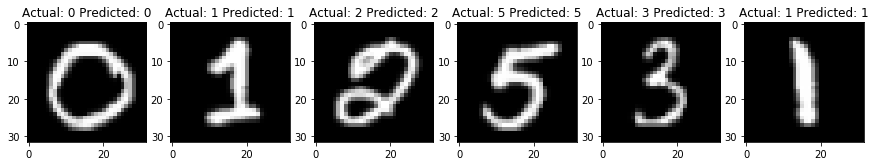

In [269]:
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Actual: {} Predicted: {}".format(example_targets[i], output.data.max(1, keepdim=True)[1][i].item()))
plt

In [270]:
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = model(example_data)

<module 'matplotlib.pyplot' from '/anaconda3/envs/FunnelAI/lib/python3.6/site-packages/matplotlib/pyplot.py'>

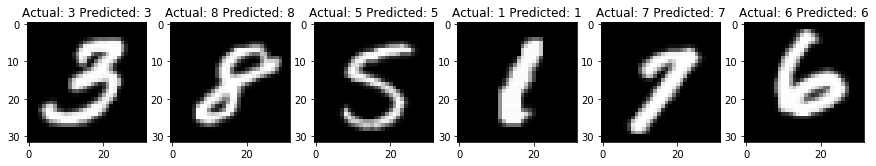

In [271]:
fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Actual: {} Predicted: {}".format(example_targets[i], output.data.max(1, keepdim=True)[1][i].item()))
plt

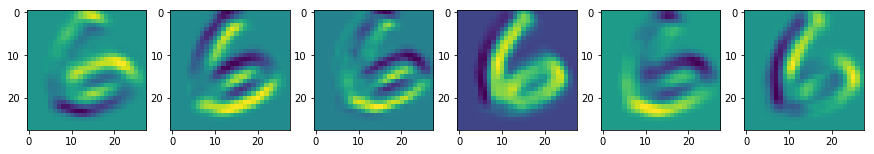

In [365]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.c1.register_forward_hook(get_activation('c1'))
data = example_data[5]

data.unsqueeze_(0)
output = model(data)

act = activation['c1'].squeeze()

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(act[i])

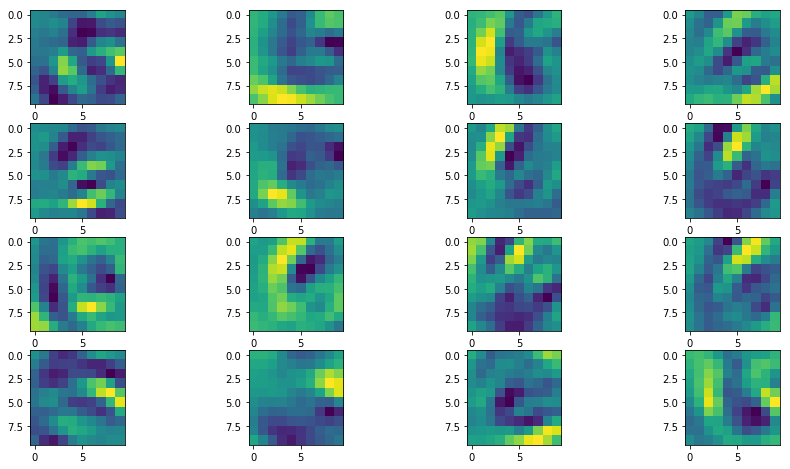

In [366]:
model.c3.register_forward_hook(get_activation('c3'))
data  = example_data[5]
data.unsqueeze_(0)
output = model(data)

act = activation['c3'].squeeze()

fig = plt.figure(figsize=(15, 8))
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(act[i])

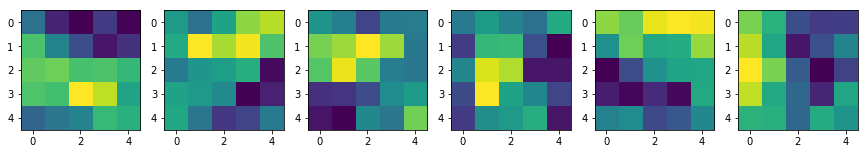

In [304]:
# Visualize conv filter

fig = plt.figure(figsize=(15, 8))

kernels = model.c1.weight.detach()
for idx in range(kernels.size(0)):
    plt.subplot(1,6, idx+1)
    plt.imshow(kernels[idx].squeeze())


torch.Size([16, 6, 5, 5])


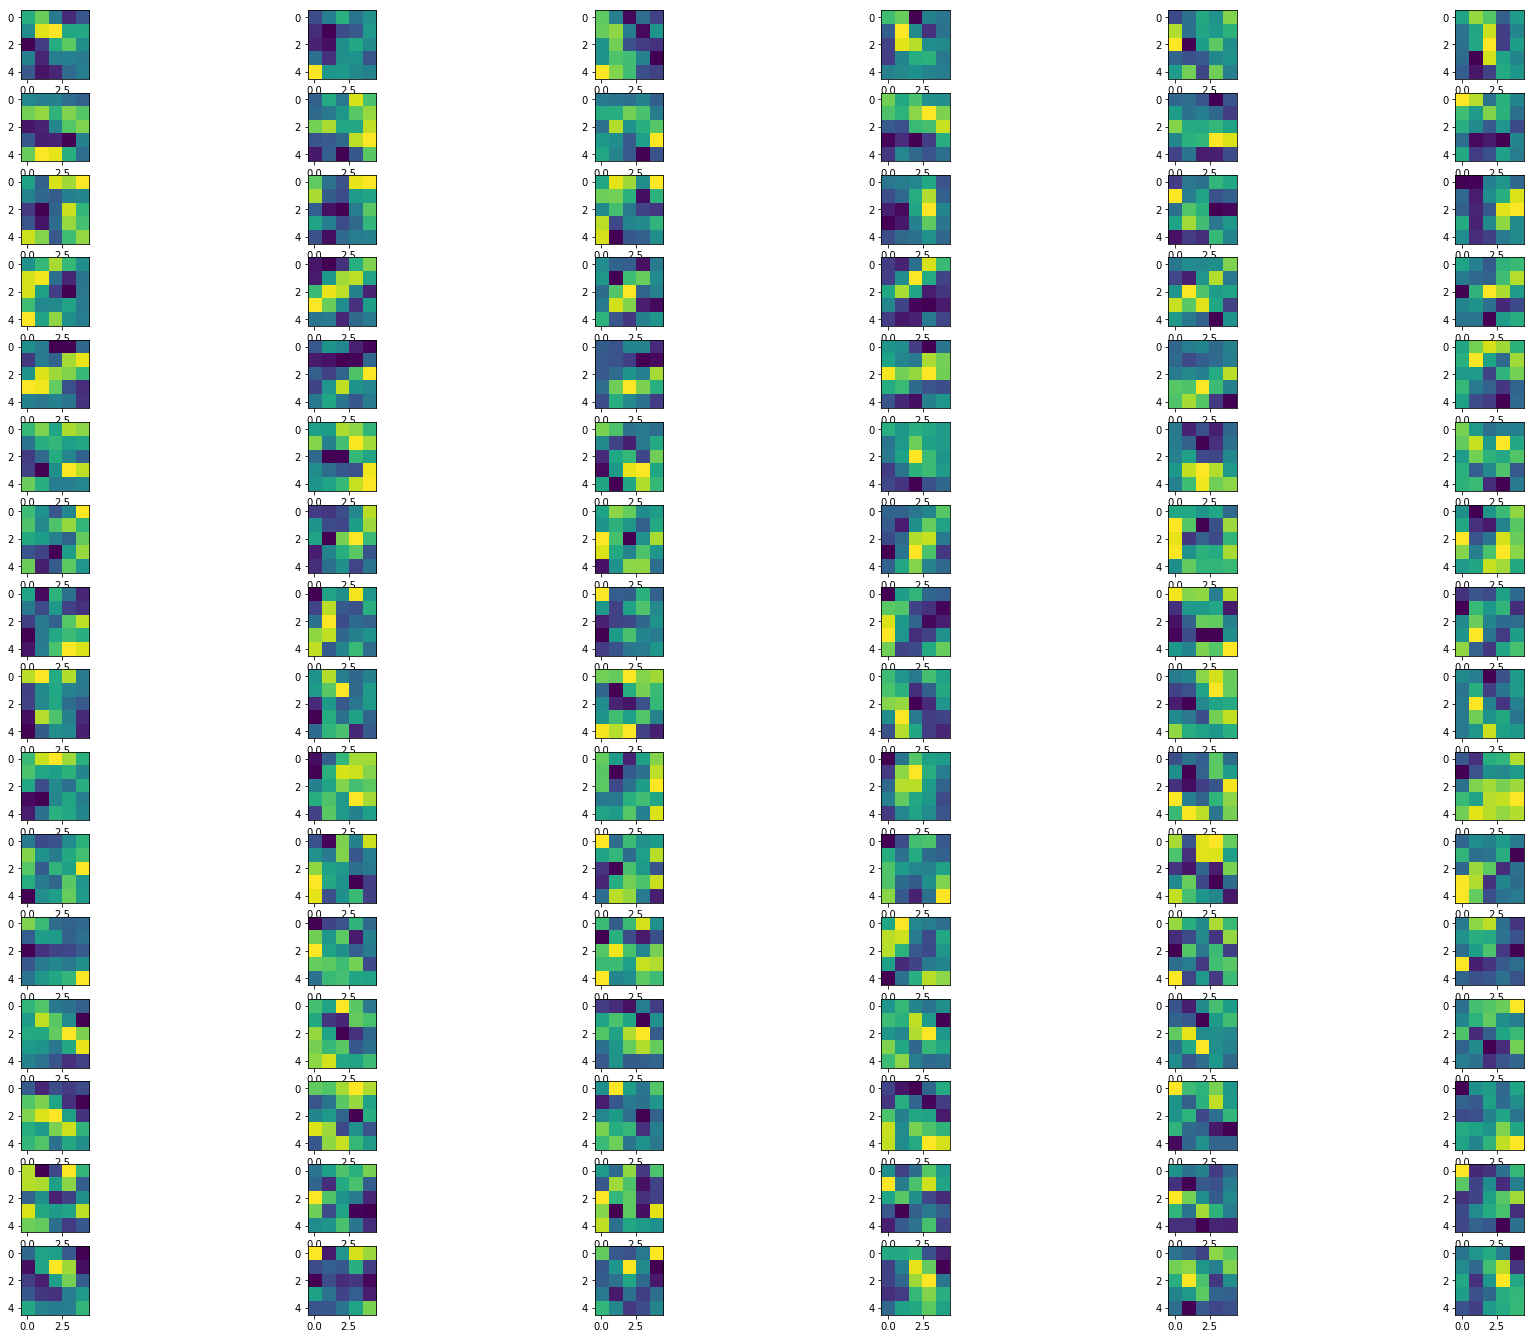

In [364]:
fig = plt.figure(figsize=(30, 24))

kernels = model.c3.weight.detach()
print(kernels.size())

count = 1
for j in range(1,17):
    for idx in range(1,7):
        plt.subplot(16,6, count)
        count += 1
        plt.imshow(kernels[j-1][idx-1].squeeze())